# Chapter 17 The BATS Model

## Listing 17-1. Import the data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the data
df = pd.read_csv('hierarchical_sales_data.csv')

df_sum = df[['DATE']]

# Sum the sales and promos of the different products
df_sum['SALES'] = df[[x for x in df.columns if x.startswith('QTY')]].sum(axis=1)
df_sum['PROMO'] = df[[x for x in df.columns if x.startswith('PROMO')]].sum(axis=1)

# Create sum of sales and promos per month
df_sum['YEAR_MONTH'] = df_sum['DATE'].apply(lambda x: x[:7])
df_sum = df_sum[['SALES', 'PROMO', 'YEAR_MONTH']].groupby('YEAR_MONTH').sum()
df_sum.head()

# Preview the data
df_sum.head()


/var/folders/5z/nxlf2r4n5yx6qy1wbzvkr3xr0000gn/T/ipykernel_17186/896776394.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sum['SALES'] = df[[x for x in df.columns if x.startswith('QTY')]].sum(axis=1)
/var/folders/5z/nxlf2r4n5yx6qy1wbzvkr3xr0000gn/T/ipykernel_17186/896776394.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sum['PROMO'] = df[[x for x in df.columns if x.startswith('PROMO')]].sum(axis=1)
/var/folders/5z/nxlf2r4n5yx6qy1wbzvkr3xr0000gn/T/ipykernel_17186/896776394.py:14: SettingWit

,SALES,PROMO
YEAR_MONTH,,
2014-01,12819,990
2014-02,17906,1329
2014-03,12047,896
2014-04,15998,1235
2014-05,17453,1354


## Listing 17-2. Plot the data

(array([-10.,   0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.]),
 [Text(-10.0, 0, '2018-03'),
  Text(0.0, 0, '2014-01'),
  Text(10.0, 0, '2014-11'),
  Text(20.0, 0, '2015-09'),
  Text(30.0, 0, '2016-07'),
  Text(40.0, 0, '2017-05'),
  Text(50.0, 0, '2018-03'),
  Text(60.0, 0, ''),
  Text(70.0, 0, '')])

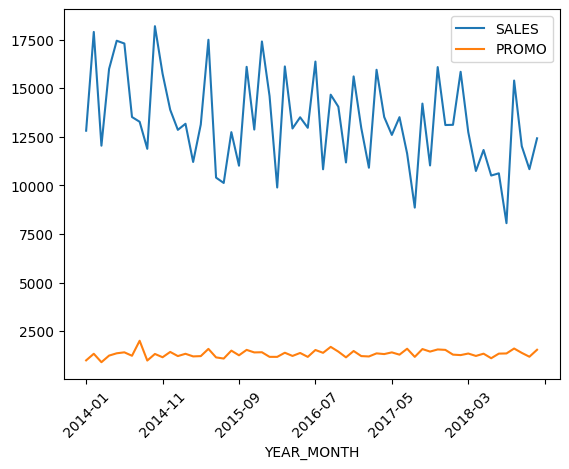

In [2]:
df_sum.plot()
plt.xticks(rotation=45)

## Listing 17-3. Investigate if there is a correlation

(array([-10.,   0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.]),
 [Text(-10.0, 0, '2018-03'),
  Text(0.0, 0, '2014-01'),
  Text(10.0, 0, '2014-11'),
  Text(20.0, 0, '2015-09'),
  Text(30.0, 0, '2016-07'),
  Text(40.0, 0, '2017-05'),
  Text(50.0, 0, '2018-03'),
  Text(60.0, 0, ''),
  Text(70.0, 0, '')])

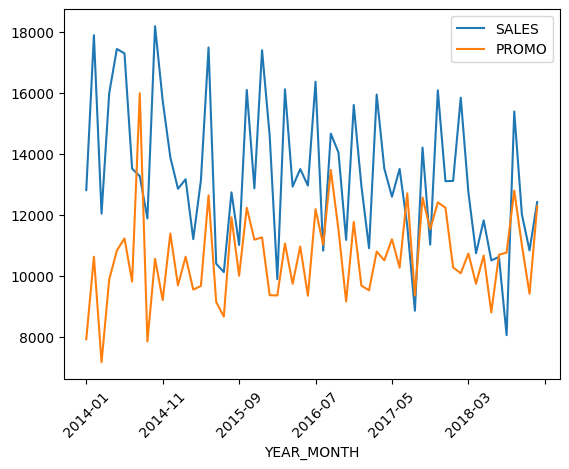

In [3]:
df_scaled = df_sum[['SALES']]
df_scaled['PROMO'] = df_sum['PROMO'] * 8

df_scaled.plot()
plt.xticks(rotation=45)

## Listing 17-4. Investigate if there is a correlation pt 2

<Axes: xlabel='PROMO', ylabel='SALES'>

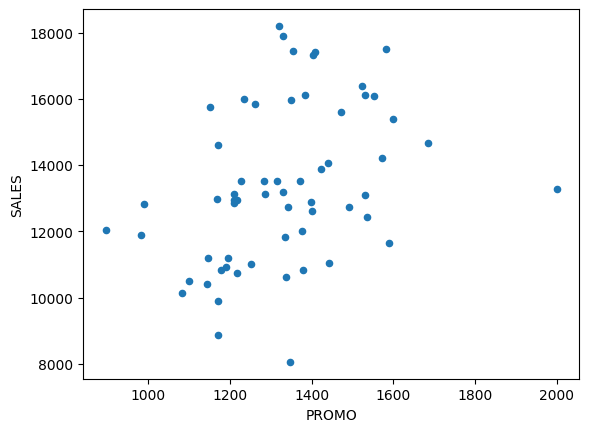

In [4]:
df_sum.plot.scatter(x='PROMO',y='SALES')

## Listing 17-5. Investigate if there is a correlation pt 3

In [5]:
df_sum.corr()

,SALES,PROMO
SALES,1.000000,0.358155
PROMO,0.358155,1.000000


## Listing 17-6. Univariate forecast, using poisson family

In [6]:
from pybats.analysis import *
from pybats.point_forecast import *
from pybats.plot import *

import mlflow
mlflow.autolog()

Y = df_sum['SALES']

k = 1 # forecasting one day into the future
forecast_start = 0 
forecast_end = len(df_sum)-1



mod, samples = analysis(Y, 
                        family="poisson",
                        forecast_start=forecast_start,
                        forecast_end=forecast_end,
                        k=k,
                        nsamps=100,
                        prior_length=6,
                        rho=.5,
                        deltrend=0.95,
                        delregn=0.95
                        )

2025/06/06 12:03:26 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2025/06/06 12:03:26 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '899a5060b3ec4a6eac231df44a172afd', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current statsmodels workflow
2025/06/06 12:03:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/06/06 12:03:28 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/anaconda3/envs/chapter17/lib/python3.9/site-packages/statsmodels/genmod/generalized_linear_model.py:1923: FutureWarning: The bic value is computed using the deviance formula. After 0.13 this will change to the log-likelihood based formula. This change has no impact on the relative rank of models compared using BIC. You can directl

## Listing 17-7. Get coefficients

In [7]:
print(mod.get_coef())

           Mean  Standard Deviation
Intercept  9.43                 0.0


## Listing 17-8. Build the forecast and analyze results

2025/06/06 12:03:35 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.


0.8327960444517383


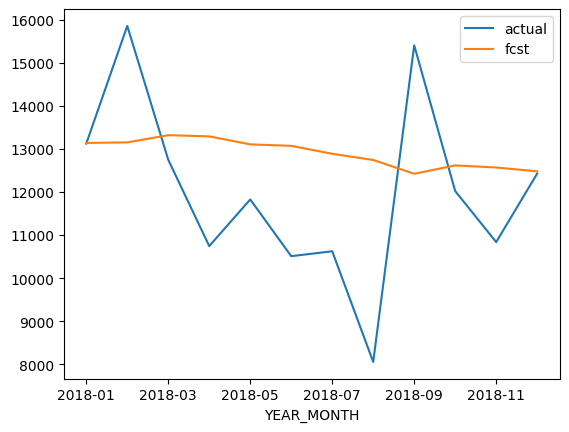

In [8]:
# Compute the forecast for the full period
fcst = median(samples)

# Compute r2 score
from sklearn.metrics import mean_absolute_percentage_error
percentage_score = 1 - mean_absolute_percentage_error(Y[-12:], pd.Series(fcst.reshape(60)[-12:]))
print(percentage_score)

# Plot forecast of the last year
Y[-12:].plot()
pd.Series(fcst.reshape(len(Y))[-12:]).plot()
plt.legend(['actual', 'fcst'])

## Listing 17-9. Forecast with additional X variable, using normal family

2025/06/06 12:03:35 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '4c27115b9e6b4cedbacf247802d99774', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current statsmodels workflow
2025/06/06 12:03:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


0.8542155438344732


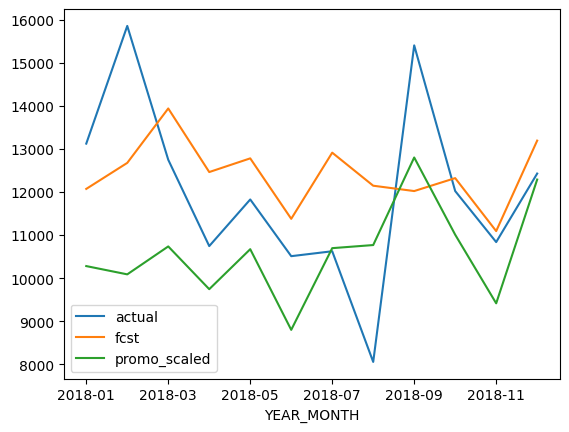

In [9]:
X = df_sum['PROMO'].values

mod, samples = analysis(Y.values,X,
                        family="normal",
                        forecast_start=forecast_start,
                        forecast_end=forecast_end,
                        k=k,
                        nsamps=100,
                        prior_length=20,
                        rho=.5,
                        deltrend=0.95,
                        delregn=0.95
                        )

# Estimate the forecast
fcst = median(samples)


# Compute the score
percentage_score = 1 - mean_absolute_percentage_error(Y[-12:], pd.Series(fcst.reshape(60)[-12:]))
print(percentage_score)

# Plot the forecast of the last year
Y[-12:].plot()
pd.Series(fcst.reshape(len(Y))[-12:]).plot()
scaled_x_future = X[-12:] * 8
pd.Series(scaled_x_future).plot()
plt.legend(['actual', 'fcst', 'promo_scaled'])